# Exploring SMM data skeleton

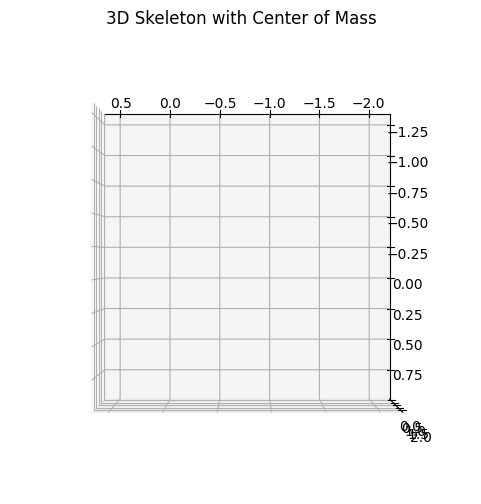

In [6]:
import matplotlib
# matplotlib.use('Agg')
matplotlib.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, writers
from mpl_toolkits.mplot3d import Axes3D

# === Load and preprocess CSV ===
csv_path = 'data/smartfallmm/young/skeleton/S31A08T02.csv'
df = pd.read_csv(csv_path, header=None).dropna()
data = df.to_numpy(dtype=np.float32)
pose_3d = data.reshape((-1, 32, 3)) / 1000.0  # normalize mm → meters

# Ground the skeleton (z=0 at lowest point)
pose_3d[:, :, 2] -= np.min(pose_3d[:, :, 2])

# Center of mass per frame
com = np.mean(pose_3d, axis=1)

# === Refined Joint Labels ===
refined_joint_labels = [
    "PELVIS", "SPINE_NAVAL", "SPINE_CHEST", "NECK",
    "CLAVICLE_LEFT", "SHOULDER_LEFT", "ELBOW_LEFT", "WRIST_LEFT", "HAND_LEFT", "HANDTIP_LEFT", "THUMB_LEFT",
    "CLAVICLE_RIGHT", "SHOULDER_RIGHT", "ELBOW_RIGHT", "WRIST_RIGHT", "HAND_RIGHT", "HANDTIP_RIGHT", "THUMB_RIGHT",
    "HIP_LEFT", "KNEE_LEFT", "ANKLE_LEFT", "FOOT_LEFT",
    "HIP_RIGHT", "KNEE_RIGHT", "ANKLE_RIGHT", "FOOT_RIGHT",
    "HEAD", "NOSE", "EYE_LEFT", "EAR_LEFT", "EYE_RIGHT", "EAR_RIGHT"
]
label_to_index = {label: i for i, label in enumerate(refined_joint_labels)}

# === Skeleton Connections ===
skeleton_connections = [
    ("PELVIS", "SPINE_NAVAL"), ("SPINE_NAVAL", "SPINE_CHEST"),
    ("SPINE_CHEST", "NECK"), ("NECK", "HEAD"), ("HEAD", "NOSE"),
    ("NOSE", "EYE_LEFT"), ("NOSE", "EYE_RIGHT"),
    ("EYE_LEFT", "EAR_LEFT"), ("EYE_RIGHT", "EAR_RIGHT"),

    ("NECK", "CLAVICLE_LEFT"), ("CLAVICLE_LEFT", "SHOULDER_LEFT"),
    ("SHOULDER_LEFT", "ELBOW_LEFT"), ("ELBOW_LEFT", "WRIST_LEFT"),
    ("WRIST_LEFT", "HAND_LEFT"), ("HAND_LEFT", "HANDTIP_LEFT"),
    ("WRIST_LEFT", "THUMB_LEFT"),

    ("NECK", "CLAVICLE_RIGHT"), ("CLAVICLE_RIGHT", "SHOULDER_RIGHT"),
    ("SHOULDER_RIGHT", "ELBOW_RIGHT"), ("ELBOW_RIGHT", "WRIST_RIGHT"),
    ("WRIST_RIGHT", "HAND_RIGHT"), ("HAND_RIGHT", "HANDTIP_RIGHT"),
    ("WRIST_RIGHT", "THUMB_RIGHT"),

    ("PELVIS", "HIP_LEFT"), ("HIP_LEFT", "KNEE_LEFT"),
    ("KNEE_LEFT", "ANKLE_LEFT"), ("ANKLE_LEFT", "FOOT_LEFT"),

    ("PELVIS", "HIP_RIGHT"), ("HIP_RIGHT", "KNEE_RIGHT"),
    ("KNEE_RIGHT", "ANKLE_RIGHT"), ("ANKLE_RIGHT", "FOOT_RIGHT")
]

# === Plot setup ===
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

mins, maxs = np.min(pose_3d, axis=(0, 1)), np.max(pose_3d, axis=(0, 1))
padding = 0.1 * (maxs - mins)
ax.set_xlim([mins[0] - padding[0], maxs[0] + padding[0]])
ax.set_ylim([mins[1] - padding[1], maxs[1] + padding[1]])
ax.set_zlim([mins[2] - padding[2], maxs[2] + padding[2]])
ax.view_init(elev=90, azim=90)  # Front view
ax.set_title("3D Skeleton with Center of Mass")

# === Create animation lines ===
lines = [ax.plot([], [], [], 'k', linewidth=2)[0] for _ in skeleton_connections]
com_dot, = ax.plot([], [], [], 'o', color='green', markersize=8)

def init():
    for line in lines:
        line.set_data([], [])
        line.set_3d_properties([])
    com_dot.set_data([], [])
    com_dot.set_3d_properties([])
    return lines + [com_dot]

def update(frame):
    joints = pose_3d[frame]
    for line, (a, b) in zip(lines, skeleton_connections):
        i, j = label_to_index[a], label_to_index[b]
        line.set_data([joints[i, 0], joints[j, 0]],
                      [joints[i, 1], joints[j, 1]])
        line.set_3d_properties([joints[i, 2], joints[j, 2]])
    com_dot.set_data([com[frame, 0]], [com[frame, 1]])
    com_dot.set_3d_properties([com[frame, 2]])
    ax.set_title(f"Frame {frame}")
    return lines + [com_dot]

# === Animate ===
ani = FuncAnimation(fig, update, frames=len(pose_3d),
                    init_func=init, interval=40, blit=True)

# === Save ===
#os.makedirs("./output", exist_ok=True)
#output_path = "./output/animation_S31A08T02.mp4"
#ani.save(output_path, writer=writers['ffmpeg'](fps=25, metadata=dict(artist='Pose3D'), bitrate=30000))

#print("✅ Animation saved to:", output_path)


# Plotting static frame with center of mass

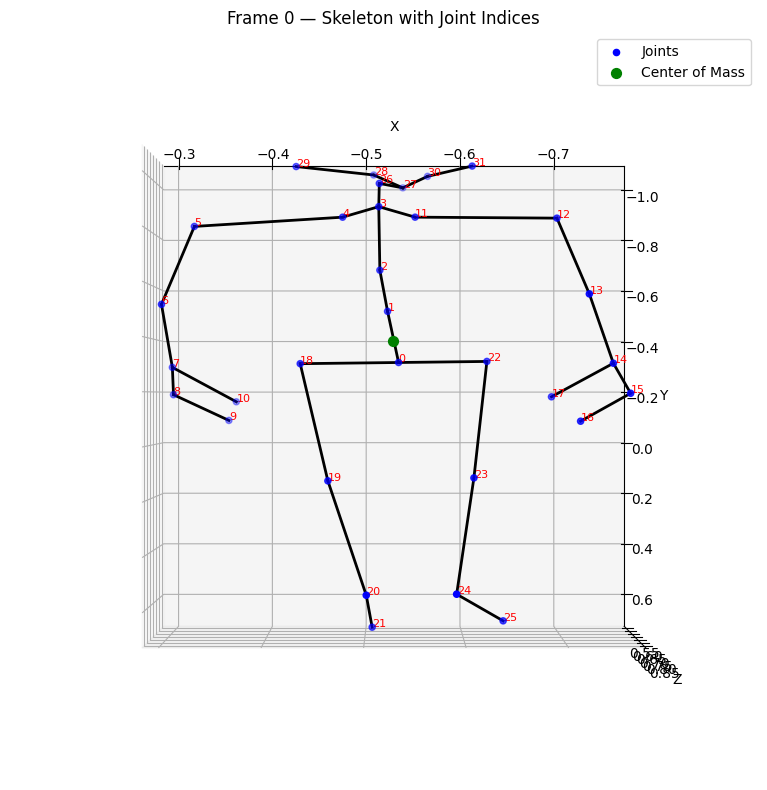

In [8]:
# Use the provided joint order reference image — this is the correct joint index-to-label mapping
refined_joint_labels = [
    "PELVIS", "SPINE_NAVAL", "SPINE_CHEST", "NECK",
    "CLAVICLE_LEFT", "SHOULDER_LEFT", "ELBOW_LEFT", "WRIST_LEFT", "HAND_LEFT", "HANDTIP_LEFT", "THUMB_LEFT",
    "CLAVICLE_RIGHT", "SHOULDER_RIGHT", "ELBOW_RIGHT", "WRIST_RIGHT", "HAND_RIGHT", "HANDTIP_RIGHT", "THUMB_RIGHT",
    "HIP_LEFT", "KNEE_LEFT", "ANKLE_LEFT", "FOOT_LEFT",
    "HIP_RIGHT", "KNEE_RIGHT", "ANKLE_RIGHT", "FOOT_RIGHT",
    "HEAD", "NOSE", "EYE_LEFT", "EAR_LEFT", "EYE_RIGHT", "EAR_RIGHT"
]
refined_label_to_index = {label: i for i, label in enumerate(refined_joint_labels)}

# Define skeleton connections according to the refined diagram
refined_skeleton_connections = [
    # Spine & head
    ("PELVIS", "SPINE_NAVAL"), ("SPINE_NAVAL", "SPINE_CHEST"),
    ("SPINE_CHEST", "NECK"), ("NECK", "HEAD"), ("HEAD", "NOSE"),
    ("NOSE", "EYE_LEFT"), ("NOSE", "EYE_RIGHT"),
    ("EYE_LEFT", "EAR_LEFT"), ("EYE_RIGHT", "EAR_RIGHT"),

    # Left arm
    ("NECK", "CLAVICLE_LEFT"), ("CLAVICLE_LEFT", "SHOULDER_LEFT"),
    ("SHOULDER_LEFT", "ELBOW_LEFT"), ("ELBOW_LEFT", "WRIST_LEFT"),
    ("WRIST_LEFT", "HAND_LEFT"), ("HAND_LEFT", "HANDTIP_LEFT"),
    ("WRIST_LEFT", "THUMB_LEFT"),

    # Right arm
    ("NECK", "CLAVICLE_RIGHT"), ("CLAVICLE_RIGHT", "SHOULDER_RIGHT"),
    ("SHOULDER_RIGHT", "ELBOW_RIGHT"), ("ELBOW_RIGHT", "WRIST_RIGHT"),
    ("WRIST_RIGHT", "HAND_RIGHT"), ("HAND_RIGHT", "HANDTIP_RIGHT"),
    ("WRIST_RIGHT", "THUMB_RIGHT"),

    # Legs
    ("PELVIS", "HIP_LEFT"), ("HIP_LEFT", "KNEE_LEFT"),
    ("KNEE_LEFT", "ANKLE_LEFT"), ("ANKLE_LEFT", "FOOT_LEFT"),

    ("PELVIS", "HIP_RIGHT"), ("HIP_RIGHT", "KNEE_RIGHT"),
    ("KNEE_RIGHT", "ANKLE_RIGHT"), ("ANKLE_RIGHT", "FOOT_RIGHT")
]

# Replot the corrected human skeleton
frame = 0
joints = pose_3d[frame]

# Redraw the plot with joint index labels added to each point
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot joints
ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], c='blue', s=20, label='Joints')

# Plot bones using refined structure
for joint_name_a, joint_name_b in refined_skeleton_connections:
    i, j = refined_label_to_index[joint_name_a], refined_label_to_index[joint_name_b]
    ax.plot([joints[i, 0], joints[j, 0]],
            [joints[i, 1], joints[j, 1]],
            [joints[i, 2], joints[j, 2]], 'k', linewidth=2)

# Annotate joints with index
for i, (x, y, z) in enumerate(joints):
    ax.text(x, y, z, f"{i}", color='red', fontsize=8)

# Plot center of mass
ax.scatter(com[frame, 0], com[frame, 1], com[frame, 2], c='green', s=50, label='Center of Mass')

# Set plot bounds and view
ax.set_xlim([np.min(joints[:, 0]), np.max(joints[:, 0])])
ax.set_ylim([np.min(joints[:, 1]), np.max(joints[:, 1])])
ax.set_zlim([np.min(joints[:, 2]), np.max(joints[:, 2])])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=90, azim=90)
ax.legend()
ax.set_title("Frame 0 — Skeleton with Joint Indices")

plt.tight_layout()
plt.show()

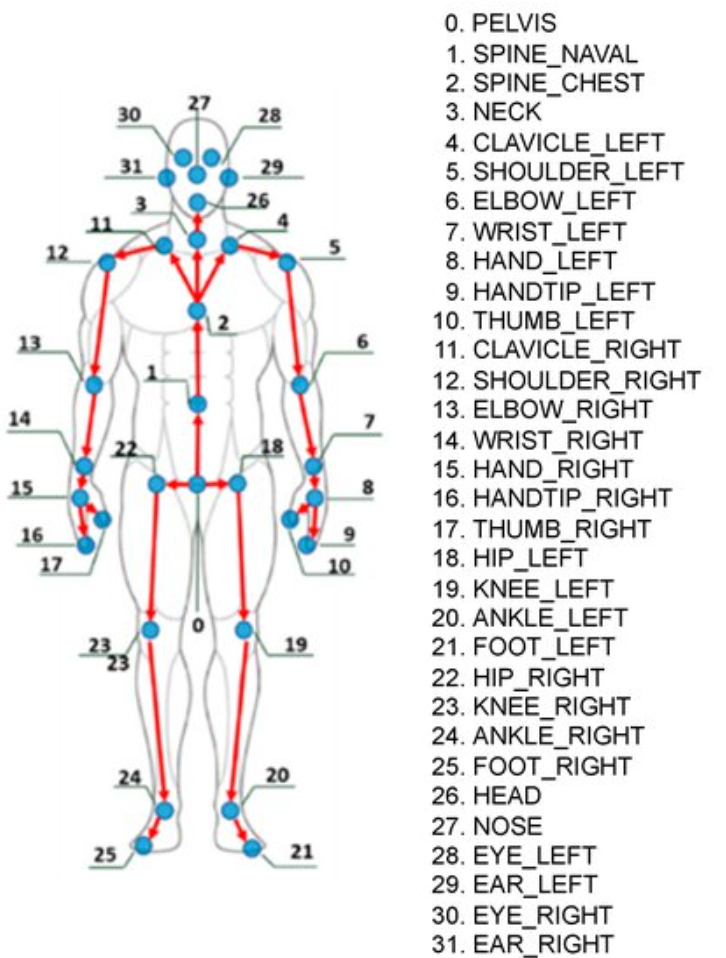

# Extracting gait statistics from skeleton based on Dr. Chang's code

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from numpy.linalg import svd

# ------------------------
# Ground Alignment Helpers
# ------------------------
def fit_ground_plane(points):
    mean_pts = np.mean(points, axis=0)
    centered = points - mean_pts
    _, _, V = svd(centered)
    normal = V[-1]
    return normal, mean_pts

def compute_rotation_matrix_to_align_with_z(normal):
    z_axis = np.array([0, 0, 1])
    normal = normal / np.linalg.norm(normal)
    v = np.cross(normal, z_axis)
    s = np.linalg.norm(v)
    if s == 0:
        return np.eye(3)
    c = np.dot(normal, z_axis)
    vx = np.array([[0, -v[2], v[1]],
                   [v[2], 0, -v[0]],
                   [-v[1], v[0], 0]])
    R = np.eye(3) + vx + vx @ vx * ((1 - c) / (s ** 2))
    return R

def rotate_and_align(pose):
    T, J, _ = pose.shape
    left_foot = pose[:, 27, :]
    right_foot = pose[:, 31, :]
    z_left = gaussian_filter1d(left_foot[:, 2], sigma=1)
    z_right = gaussian_filter1d(right_foot[:, 2], sigma=1)

    locs_left, _ = find_peaks(-z_left, distance=10)
    locs_right, _ = find_peaks(-z_right, distance=10)

    contact_points = np.concatenate([left_foot[locs_left], right_foot[locs_right]])
    normal, origin = fit_ground_plane(contact_points)
    R1 = compute_rotation_matrix_to_align_with_z(normal)
    pose_rot = (R1 @ (pose - origin).reshape(-1, 3).T).T.reshape(T, J, 3)
    return pose_rot

# ------------------------
# Gait Feature Computation
# ------------------------
def compute_center_of_mass(pose):
    return np.mean(pose, axis=1)  # simple mean of all joints

def detect_gait_events(pose):
    z_left = -gaussian_filter1d(pose[:, 27, 2], sigma=1)
    peaks_left, _ = find_peaks(-z_left, distance=10)
    return peaks_left

def export_gait_summary_to_csv(data, filename="gait_features_smm.csv"):
    df = pd.DataFrame([data])
    df.to_csv(filename, index=False, sep=';')

# ------------------------
# Load CSV and Run Pipeline
# ------------------------
csv_path = 'smartfallmm/young/skeleton/S35A08T01.csv'  # <- replace with your CSV file path
df = pd.read_csv(csv_path, header=None).dropna()
data = df.to_numpy(dtype=np.float32)
pose_3d = data.reshape((-1, 32, 3)) / 1000.0  # mm -> m
pose_3d[:, :, 2] -= np.min(pose_3d[:, :, 2])  # Ground to z = 0

# Align to ground
pose_aligned = rotate_and_align(pose_3d)

# CoM over time
com = compute_center_of_mass(pose_aligned)

# Detect stride segments (using left foot)
peaks_left = detect_gait_events(pose_aligned)
stride_segments = list(zip(peaks_left[:-1], peaks_left[1:]))

# Compute CoM movement features across strides
CoM_fore_aft = [com[b, 0] - com[a, 0] for a, b in stride_segments]
CoM_width = [np.max(com[a:b, 1]) - np.min(com[a:b, 1]) for a, b in stride_segments]
CoM_height = [np.max(com[a:b, 2]) - np.min(com[a:b, 2]) for a, b in stride_segments]

# Create summary
gait_summary = {
    "Mean CoM Fore Aft": np.mean(CoM_fore_aft),
    "StDev CoM Fore Aft": np.std(CoM_fore_aft),
    "Mean CoM Width": np.mean(CoM_width),
    "StDev CoM Width": np.std(CoM_width),
    "Mean CoM Height": np.mean(CoM_height),
    "StDev CoM Height": np.std(CoM_height),
}

# Export to CSV and print
export_gait_summary_to_csv(gait_summary)
print(pd.DataFrame([gait_summary]))


   Mean CoM Fore Aft  StDev CoM Fore Aft  Mean CoM Width  StDev CoM Width  \
0           0.025686            0.241545        0.236868         0.127868   

   Mean CoM Height  StDev CoM Height  
0         0.043789          0.018567  
